<class 'pandas.core.frame.DataFrame'>
Index: 230736 entries, 230736 to 461471
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      230736 non-null  datetime64[ns]
 1   y       230736 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23741 entries, 0 to 23740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23741 non-null  datetime64[ns]
 1   y       23741 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 371.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      228 non-null    datetime64[ns]
 1   y       228 non-null    float64       
dtypes: datetime64[ns](1),

C:\Users\rafae\AppData\Local\Temp\ipykernel_28360\395939822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


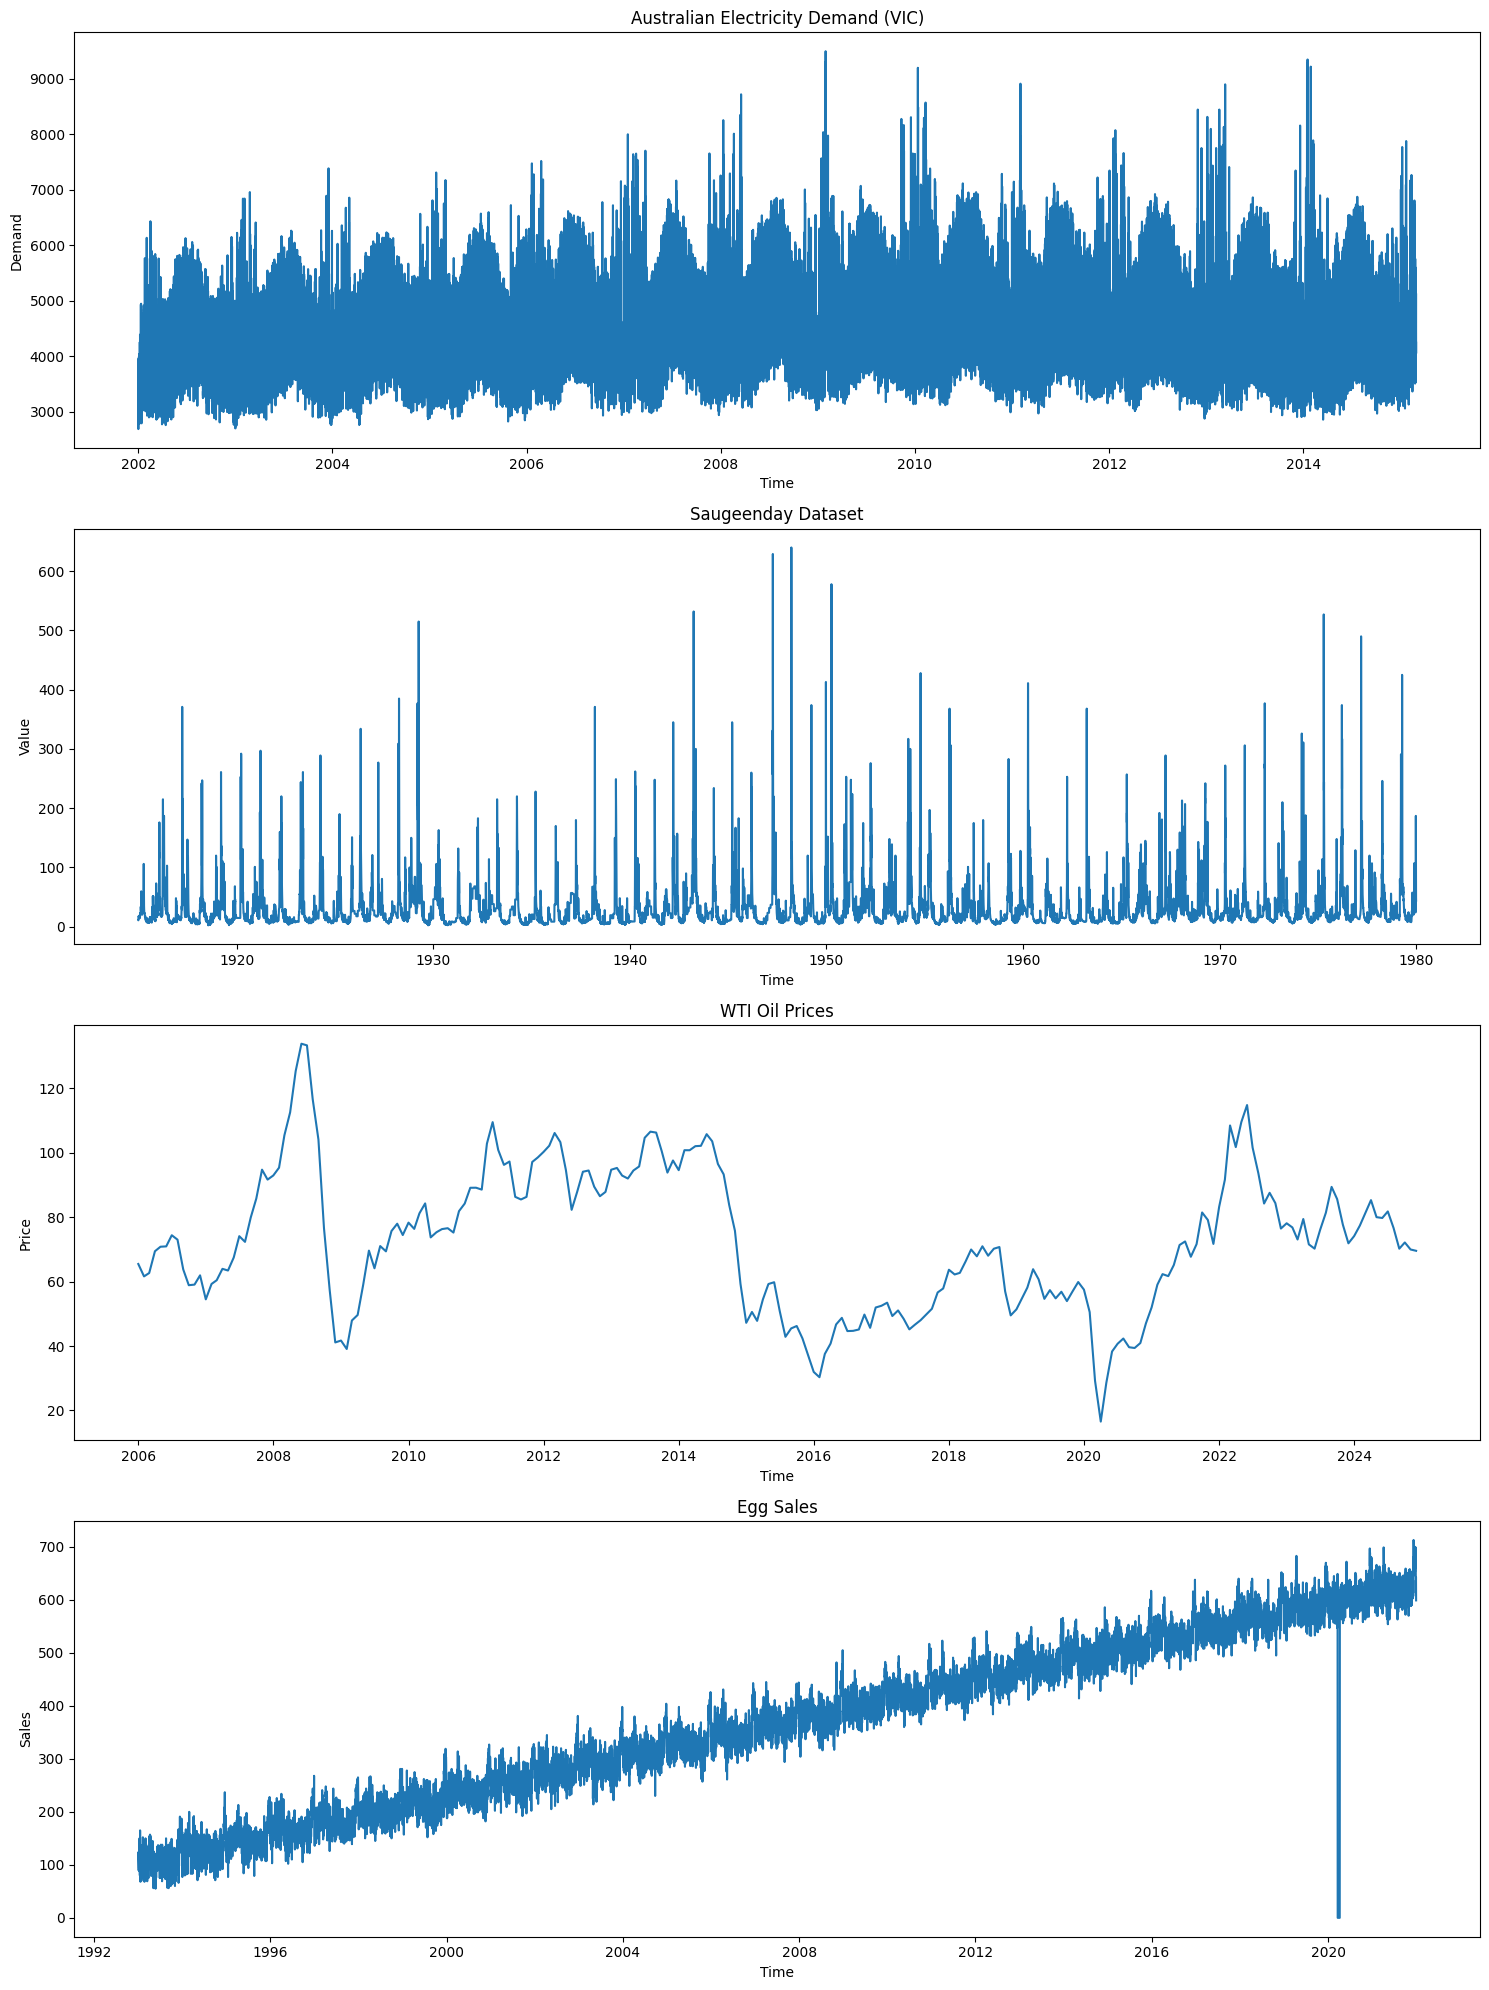

In [5]:
%run "datagetter.ipynb"

- Australian Eletricity Demand in Victoria City

In [6]:
dataset_path = './Datasets/'
dataset_name = 'australian_electricity_demand_dataset.tsf'
australian_ds = load_dataset(dataset_path + dataset_name)[0]

In [7]:
# Reset the index to turn multi-index into columns
df = australian_ds.reset_index()

# Filter for Victoria state
df_vic = df[df['state'] == 'VIC']

# Keep only timestamp and value, rename for Prophet/LSTM
df_vic = df_vic[['timestamp', 'series_value']].rename(
    columns={'timestamp': 'ds', 'series_value': 'y'}
)

# Make sure 'ds' is datetime
df_vic['ds'] = pd.to_datetime(df_vic['ds'])

# Sort for time order
df_vic = df_vic.sort_values('ds')

# Now you have a flat DataFrame ready for daily aggregation or modeling!
print(df_vic.head())


                        ds            y
230736 2002-01-01 00:00:00  3535.867064
230737 2002-01-01 00:30:00  3383.499028
230738 2002-01-01 01:00:00  3655.527552
230739 2002-01-01 01:30:00  3510.446636
230740 2002-01-01 02:00:00  3294.697156


In [8]:
# Daily aggregation
# Aggregate half-hourly to daily sum
daily = (
    df_vic
      .set_index('ds')['y']
      .resample('D').sum()
      .dropna()
      .to_frame()
      .reset_index()
)
print(daily.head())


          ds              y
0 2002-01-01  148141.537386
1 2002-01-02  171638.934840
2 2002-01-03  175124.021236
3 2002-01-04  176189.124798
4 2002-01-05  165421.580800


In [10]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

daily = (
    df_vic
      .set_index('ds')['y']
      .resample('D').sum()
      .dropna()
      .to_frame()
      .reset_index()
)
# Only the values for LSTM
values = daily['y'].values.reshape(-1, 1)

# Scale to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [12]:
import numpy as np
# How many days to use for each input sequence
LOOKBACK = 14  # two weeks, adjust if you want

X, y = [], []
for i in range(LOOKBACK, len(scaled)):
    X.append(scaled[i-LOOKBACK:i, 0])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [13]:
SPLIT = int(0.8 * len(X))  # 80% train, 20% test
X_train, X_test = X[:SPLIT], X[SPLIT:]
y_train, y_test = y[:SPLIT], y[SPLIT:]


In [15]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0585 - val_loss: 0.0134
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0131
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0125
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0127
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [16]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


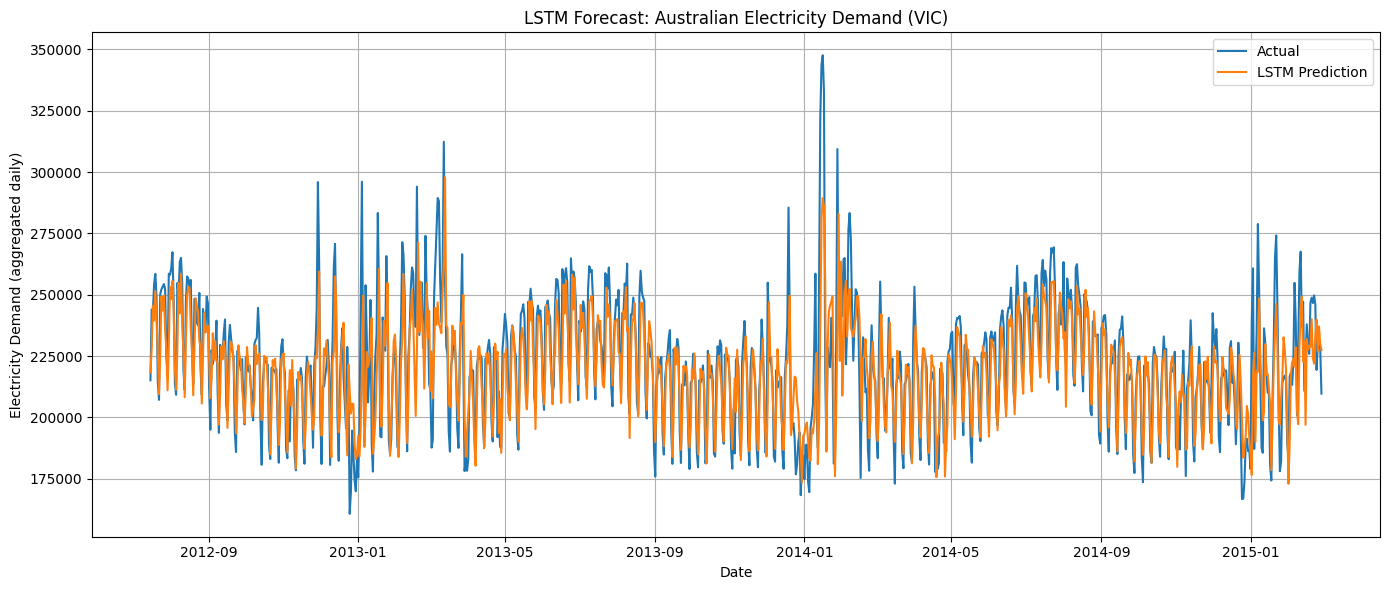

In [17]:
import matplotlib.dates as mdates

# Get corresponding dates for test set
test_dates = daily['ds'].iloc[-len(y_test):]

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_inv, label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (aggregated daily)')
plt.title('LSTM Forecast: Australian Electricity Demand (VIC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")


LSTM MAE: 11553.24
LSTM MAPE: 5.12%


- Saugeenday Dataset

In [21]:
dataset_path = './Datasets/'
dataset_name = 'australian_electricity_demand_dataset.tsf'
saugeenday_ds = load_dataset(dataset_path + dataset_name)[1]

In [38]:
daily = (
    saugeen_river_df
    .set_index('ds')['y']
    .resample('D').sum()  
    .dropna()
    .to_frame()
    .reset_index()
)
print(daily.head())


          ds     y
0 1915-01-01  11.5
1 1915-01-02  10.8
2 1915-01-03  13.7
3 1915-01-04  13.7
4 1915-01-05  14.4


In [39]:
# Use only the values for scaling and LSTM
values = daily['y'].values.reshape(-1, 1)

# Scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Set lookback window (e.g., 14 days)
lookback = 14

X, y = [], []
for i in range(len(scaled) - lookback):
    X.append(scaled[i:i+lookback, 0])
    y.append(scaled[i+lookback, 0])
X = np.array(X)
y = np.array(y)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split train/test (e.g., last 365 days for test)
split = -365 if len(y) > 365 else int(len(y)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [40]:
model = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/10


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0128 - val_loss: 0.0107
Epoch 2/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 3/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0062 - val_loss: 0.0089
Epoch 4/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 5/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 6/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 7/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0061 - val_loss: 0.0078
Epoch 8/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 9/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 10/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0060 - val_loss: 0.0076


In [41]:
# Predict
y_pred = model.predict(X_test)

# Invert scaling
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


LSTM MAE: 4.87
LSTM MAPE: 8.11%


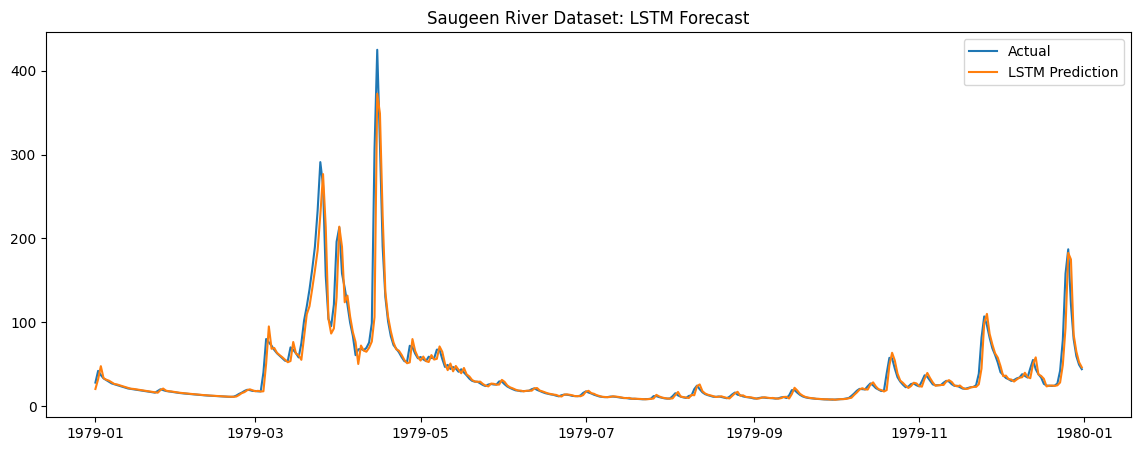

In [42]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(14,5))
plt.plot(daily['ds'].iloc[-len(y_test_inv):], y_test_inv, label='Actual')
plt.plot(daily['ds'].iloc[-len(y_test_inv):], y_pred_inv, label='LSTM Prediction')
plt.legend()
plt.title('Saugeen River Dataset: LSTM Forecast')
plt.show()


- WTI Oil Dataset

In [49]:
import pandas as pd

# 1. Load the dataset using datagetter's loader
dataset_path = './Datasets/'
dataset_names = [
    'australian_electricity_demand_dataset.tsf',
    'saugeenday_dataset.tsf',
    'wti_oil_dataset.csv',
    'train_egg_sales.csv'
]

wti_oil_dataset = load_dataset(dataset_path + dataset_names[2], delimiter=',')

# 2. Rename columns for Prophet/LSTM/SARIMA
wti_oil_dataset = wti_oil_dataset.rename(columns={'date': 'ds', 'wti': 'y'})

# 3. Keep only ds and y columns
wti_oil_df = wti_oil_dataset[['ds', 'y']]

# 4. Ensure 'ds' is datetime and sort by date
wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])
wti_oil_df = wti_oil_df.sort_values('ds')

# 5. (Optional, but good) Reset index
wti_oil_df = wti_oil_df.reset_index(drop=True)

print(wti_oil_df.tail())


            ds          y
223 2024-08-01  76.683182
224 2024-09-01  70.236000
225 2024-10-01  72.164348
226 2024-11-01  69.987000
227 2024-12-01  69.578182


C:\Users\rafae\AppData\Local\Temp\ipykernel_28360\3986223691.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


In [50]:
df = wti_oil_df.copy()

# Sort by date (already sorted above, but just in case)
df = df.sort_values('ds').reset_index(drop=True)

# If not daily, consider resampling (skip if already daily)
# df = df.set_index('ds').resample('D').mean().dropna().reset_index()

# Use only the 'y' values for LSTM
values = df['y'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [51]:
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 30   # Number of previous days to use for prediction
X, y = create_sequences(scaled, lookback=lookback)


In [52]:
split = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [53]:
model = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4059
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2585 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1434 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0711 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0298 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0300 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0306 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0239 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0242 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0246 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0201 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

In [54]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# For plotting, recover the corresponding dates
dates_pred = df['ds'].iloc[lookback+split:].reset_index(drop=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


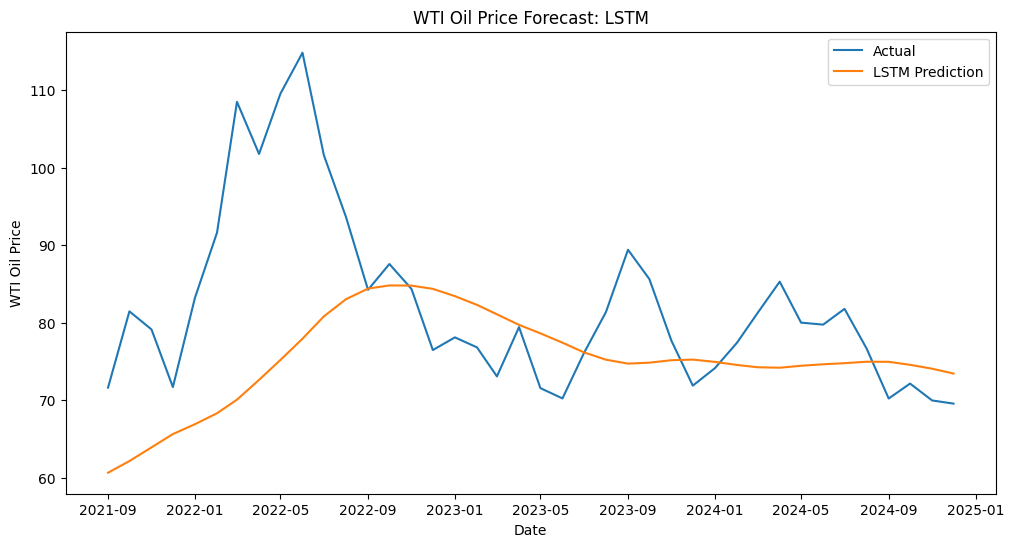

As it is small dataset, the LSTM is not able to predict the future values precisely


In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates_pred, y_true.flatten(), label='Actual')
plt.plot(dates_pred, y_pred.flatten(), label='LSTM Prediction')
plt.title('WTI Oil Price Forecast: LSTM')
plt.xlabel('Date')
plt.ylabel('WTI Oil Price')
plt.legend()
plt.show()

print("As it is small dataset, the LSTM is not able to predict the future values precisely")


In [58]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")


LSTM MAE: 10.00
LSTM MAPE: 11.18%


- Egg Sales Dataset

In [59]:
# Sort and ensure correct columns
df = egg_sales_df.sort_values('ds').reset_index(drop=True)
values = df['y'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [67]:
egg_sales_df.tail()

,ds,y
10587,2021-12-27,681
10588,2021-12-28,664
10589,2021-12-29,613
10590,2021-12-30,643
10591,2021-12-31,599


In [60]:
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 30
X, y = create_sequences(scaled, lookback=lookback)


In [61]:
split = int(len(X) * 0.8)  # 80% train
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [62]:
model = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0081
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 9/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 10/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 11/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 12/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 13/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 14/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 15/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011


In [63]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

dates_pred = df['ds'].iloc[lookback+split:].reset_index(drop=True)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


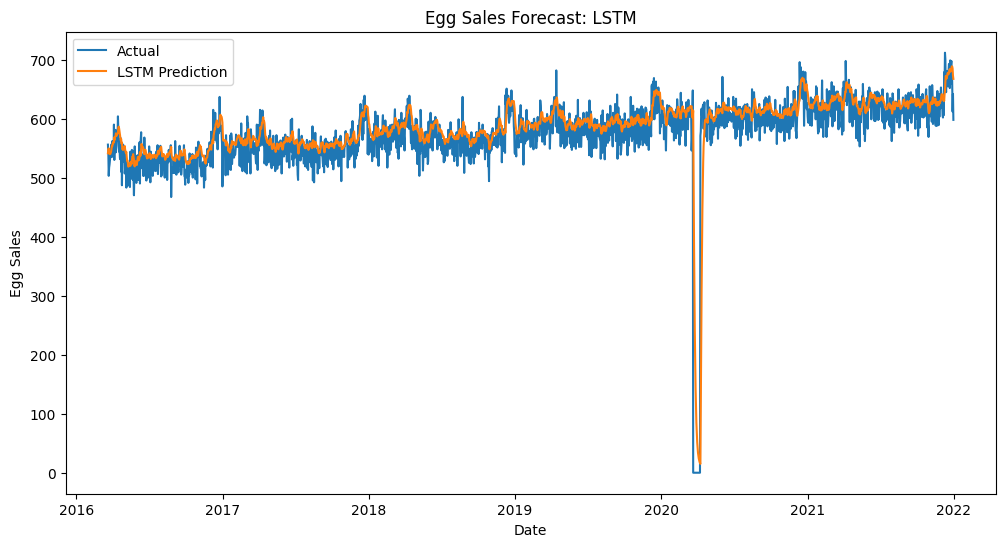

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates_pred, y_true.flatten(), label='Actual')
plt.plot(dates_pred, y_pred.flatten(), label='LSTM Prediction')
plt.title('Egg Sales Forecast: LSTM')
plt.xlabel('Date')
plt.ylabel('Egg Sales')
plt.legend()
plt.show()


In [65]:
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")


LSTM MAE: 23.07
LSTM MAPE: 618171398414085504.00%


## LSTM Pipeline Function 

Epoch 1/20


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0185
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 9/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 10/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 11/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 12/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 13/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 14/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 15/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010


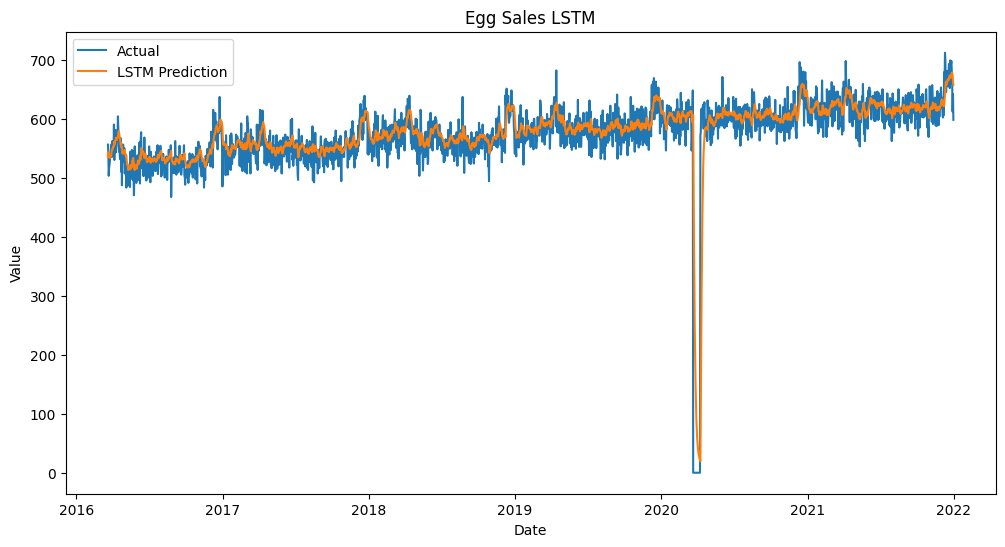

LSTM MAE: 20.89
LSTM MAPE: 629491241456792704.00%


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def lstm_forecast_pipeline(
    df, 
    lookback=30, 
    train_frac=0.8, 
    epochs=20, 
    batch_size=32,
    plot_title='LSTM Forecast'
):
    """
    Runs a full LSTM time series forecasting pipeline on a DataFrame with columns ['ds', 'y'].

    Args:
        df (pd.DataFrame): DataFrame with 'ds' (datetime) and 'y' (numeric).
        lookback (int): Length of lookback window.
        train_frac (float): Fraction of data to use for training.
        epochs (int): Training epochs.
        batch_size (int): Batch size for training.
        plot_title (str): Title for the plot.
    """
    df = df.sort_values('ds').reset_index(drop=True).copy()
    y_vals = df['y'].values.reshape(-1, 1)
    
    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler.fit_transform(y_vals)
    
    # Sequence creation
    X, y_seq = [], []
    for i in range(len(y_scaled) - lookback):
        X.append(y_scaled[i:i+lookback])
        y_seq.append(y_scaled[i+lookback])
    X = np.array(X)
    y_seq = np.array(y_seq)
    
    # Train/test split
    split = int(len(X) * train_frac)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    
    # Model
    model = Sequential([
        LSTM(32, input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test)
    dates_pred = df['ds'].iloc[lookback+split:].reset_index(drop=True)
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(dates_pred, y_true.flatten(), label='Actual')
    plt.plot(dates_pred, y_pred.flatten(), label='LSTM Prediction')
    plt.title(plot_title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"LSTM MAE: {mae:.2f}")
    print(f"LSTM MAPE: {mape:.2f}%")
    return model, mae, mape


# model, mae, mape = lstm_forecast_pipeline(australian_electricity_demand_df, lookback=30, plot_title='Australian Electricity LSTM')
# model, mae, mape = lstm_forecast_pipeline(saugeen_river_df, plot_title='Saugeen River LSTM')
# model, mae, mape = lstm_forecast_pipeline(wti_oil_df, plot_title='WTI Oil LSTM')
model, mae, mape = lstm_forecast_pipeline(egg_sales_df, plot_title='Egg Sales LSTM')
